In [1]:
from google.colab import drive
drive.mount('/content/drive')


import os

import torch
os.chdir('/content/drive/MyDrive/ImitationLearning/Invariant-Causal-Imitation-Learning-main/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load

In [2]:
!pip install mpi4py 
!pip install box2d-py
!pip install box2d 
!pip3 install gym[Box_2D] 
!pip install gym==0.17.2 -qqq
!pip install numpy~=1.18.2 -qqq
!pip install pandas~=1.0.4 -qqq
!pip install PyYAML~=5.4.1 -qqq
!pip install scikit-learn~=0.22.2 -qqq
!pip install scipy~=1.1.0 -qqq
!pip install stable-baselines~=2.10.1 -qqq
!pip install tensorflow~=1.15.0 -qqq
!pip install torch>=1.6.0 -qqq
!pip install tqdm~=4.32.1 -qqq


#config

In [3]:

config = {
    "ALG": "NFiVAE_IRMStudent_Apr28",
    "NUM_TRAJS_GIVEN": 20, #
    "NUM_TRAINING_ENVS": 2,
    "NOISE_DIM": 4,
    "REP_SIZE": 16,
    "TRAJ_SHIFT": 20, # 20,
    "SAMPLING_RATE": 5,
    "NUM_STEPS_TRAIN": 10000,
    "NUM_TRAJS_VALID": 100,
    "NUM_REPETITIONS": 15,
    "BATCH_SIZE": 64,
    "MLP_WIDTHS": 64,
    "ADAM_ALPHA": 1e-3,
    "SGLD_BUFFER_SIZE": 10000,
    "SGLD_LEARN_RATE": 0.01,
    "SGLD_NOISE_COEF": 0.01,
    "SGLD_NUM_STEPS": 100,
    "SGLD_REINIT_FREQ": 0.05,
    "NUM_STEPS_TRAIN_ENERGY_MODEL": 1000,
    'TRIAL': 0
}


config['ENV'] = "LunarLander-v2"
#config['ENV'] = "CartPole-v1"

#config['METHOD'] = "BC"
config['METHOD'] = "iVAE_IRM"



if config['METHOD'] == 'BCIRM':
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10000
    config['penalty_anneal_iters'] = 2500
elif config['METHOD'] == "iVAE_IRM":
    config["NUM_STEPS_TRAIN_VAE_MODEL"] = 1500 # phase1
    config["NUM_STEPS_TRAIN"] = 10000 # phase 3
    config['PHASE2_SAMPLES'] = 100000 # phase 2
    config['l2_regularizer_weight'] = 0.00
    config['penalty_weight'] = 0 #10
    config['BATCH_SIZE'] = 50000
    config['MODEL_TYPE'] = 'NFiVAE'
    config['SELECT_PARENTS'] = True
    config['PARENT_THRESHOLD'] = -1





#testing/il

In [4]:
import argparse
import os
import pickle

import gym
import numpy as np
import pandas as pd
import yaml
import numpy as np

from testing.paths import get_model_path, get_trajs_path  # pylint: disable=reimported

from contrib.energy_model import EnergyModel
from contrib.env_wrapper import EnvWrapper, get_test_mult_factors
from network import EnvDiscriminator
from network import FeaturesDecoder
from network import FeaturesEncoder
from network import MineNetwork 
from network import ObservationsDecoder
from network import StudentNetwork, StudentNetwork_2hidden


from student import ICILStudent, BCStudent, BCIRMStudent, iVAE_IRMStudent, NFiVAE_IRMStudent
from testing.train_utils import fill_buffer, make_agent, save_results
from vae.ivae_wrapper import VAE_wrapper
from vae.nfivae_wrapper import NFiVAE_wrapper
  
from torch import nn

/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


# make student

In [6]:


# pylint: disable=redefined-outer-name
def make_student(run_seed, config):
    env = gym.make(config["ENV"])
    trajs_path = get_trajs_path(config["ENV"], "student_" + config["ALG"], env_id="student", run_seed=run_seed)
    model_path = get_model_path(config["ENV"], "student_" + config["ALG"], run_seed=run_seed)

    state_dim = env.observation_space.shape[0] + config["NOISE_DIM"]
    action_dim = env.action_space.n
    num_training_envs = config["NUM_TRAINING_ENVS"]

    # run_seed = run_seed
    batch_size = config["BATCH_SIZE"]
    teacher = make_agent(config["ENV"], config["EXPERT_ALG"], config["NUM_TRAINING_ENVS"])
    teacher.load_pretrained()

    buffer = fill_buffer(
        trajs_path=teacher.trajs_paths,
        batch_size=batch_size,
        run_seed=run_seed,
        traj_shift=config["TRAJ_SHIFT"],
        buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
        sampling_rate=config["SAMPLING_RATE"],
    )

    if buffer.total_size < batch_size:
        batch_size = buffer.total_size



    ##########################      COMMON      ##########################

    print("state_dim", state_dim)

    causal_features_encoder = FeaturesEncoder(
        input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
    )

    policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])



    ##########################       BC       #######################

    if config['METHOD'] == 'BC':

        return BCStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


    ##########################       BC IRM       #######################


    elif config['METHOD'] == 'BCIRM':

        return BCIRMStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )



    ##########################       iVAE IRM       #######################

    elif config['METHOD'] == 'iVAE_IRM':


        print("\n ***** Start Phase 1 ***** \n")

        config['LATENT_DIM'] = state_dim #  - 3  # latent dim for iVAE, not causal-feature-encoder and policy-network

        print("latent dim = ", config['LATENT_DIM'] )
        
        ckpt_file = './vae/' + 'LunarLander_nfivae_ckpt.pt' #'./vae/' + config['ENV'] +'nfivae_ckpt.pt',
        pa_dict_file =  './vae/' + 'LunarLander_nfivae_padict.pkl' #'./vae/' + config['ENV'] +'nfivae_padict.pkl',

        vae_wrapper =  NFiVAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = config['LATENT_DIM'], 
                                   use_e = True, model_type= config['MODEL_TYPE'], lr = 1e-3, pa_dict_file = pa_dict_file, ckpt_file = ckpt_file, parents_threshold = config['PARENT_THRESHOLD'])
 
        loss_list = vae_wrapper.train(num_updates=config["NUM_STEPS_TRAIN_VAE_MODEL"])#.cpu()

        import matplotlib.pyplot as plt
        plt.plot((np.array(loss_list)))
        plt.ylim(-50,150)
        plt.show()





        ########################################

        print("\n ***** Start Phase 2 ***** \n")
        if config['SELECT_PARENTS'] == True:
            vae_wrapper.start_phase2(n_samples = config['PHASE2_SAMPLES'])
        else:
            vae_wrapper.pa_list = [0,1,2,3,4,5,6,7, 8, 9, 10, 11]
        
        policy_network = StudentNetwork(in_dim=len(vae_wrapper.pa_list), out_dim=action_dim, width=config["MLP_WIDTHS"])
        
        #phase3_obs_to_latent_encoder = Phase3ObstoLatentEncoder(obs_size = state_dim, latent_size = len(vae_wrapper.pa_list))
            #input_size=state_dim, representation_size=len(vae_wrapper.pa_list), width=config["MLP_WIDTHS"] )
        
        
        return NFiVAE_IRMStudent(
            env=env,
            vae_wrapper = vae_wrapper,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            #phase3_obs_to_latent_encoder = phase3_obs_to_latent_encoder,
            causal_features_encoder=causal_features_encoder,
            policy_network=policy_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )
        


    ##########################       ICIL        #######################

    elif config['METHOD'] == 'ICIL':
        energy_model = EnergyModel(
            in_dim=state_dim,
            width=config["MLP_WIDTHS"],
            batch_size=batch_size,
            adam_alpha=config["ADAM_ALPHA"],
            buffer=buffer,
            sgld_buffer_size=config["SGLD_BUFFER_SIZE"],
            sgld_learn_rate=config["SGLD_LEARN_RATE"],
            sgld_noise_coef=config["SGLD_NOISE_COEF"],
            sgld_num_steps=config["SGLD_NUM_STEPS"],
            sgld_reinit_freq=config["SGLD_REINIT_FREQ"],
        )
        energy_model.train(num_updates=config["NUM_STEPS_TRAIN_ENERGY_MODEL"])

        causal_features_decoder = FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        observations_decoder = ObservationsDecoder(representation_size=config["REP_SIZE"], out_size=state_dim, width=config["MLP_WIDTHS"] )

        env_discriminator = EnvDiscriminator(representation_size=config["REP_SIZE"], num_envs=config["NUM_TRAINING_ENVS"], width=config["MLP_WIDTHS"])

        noise_features_encoders = [FeaturesEncoder(input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])  
            for i in range(num_training_envs)]
        
        noise_features_decoders = [FeaturesDecoder(action_size=action_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"])
            for i in range(num_training_envs)]

        mine_network = MineNetwork(x_dim=config["REP_SIZE"], z_dim=config["REP_SIZE"], width=config["MLP_WIDTHS"])

        return ICILStudent(
            env=env,
            trajs_paths=trajs_path,
            model_path=model_path,
            num_training_envs=num_training_envs,
            teacher=teacher,
            causal_features_encoder=causal_features_encoder,
            noise_features_encoders=noise_features_encoders,
            causal_features_decoder=causal_features_decoder,
            noise_features_decoders=noise_features_decoders,
            observations_decoder=observations_decoder,
            env_discriminator=env_discriminator,
            policy_network=policy_network,
            energy_model=energy_model,
            mine_network=mine_network,
            buffer=buffer,
            adam_alpha=config["ADAM_ALPHA"],
            config = config
        )


def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--env_name", default="CartPole-v1")
    parser.add_argument("--num_trajectories", default=20, type=int)
    parser.add_argument("--trial", default=0, type=int)
    return parser.parse_args()


#10 Trails -- BC

In [ ]:
config['METHOD'] = "BC"

for traj_num in [20]:
    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "test6_BCStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "BCStudent_Apr19_replicatedata"
    #config['METHOD'] = "BC"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"
    #config["NUM_TRAJS_GIVEN"] = 20
    #config["TRAJ_SHIFT"] = 20
    ###############.  settings   ###############



    if config['METHOD'] == 'BCIRM':
        config['l2_regularizer_weight'] = 0.001
        config['penalty_weight'] = 10000
        config['penalty_anneal_iters'] = 100

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))
            student = make_student(run_seed, config)
            student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1
            )
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample
            )

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

Config: {'ENV': 'CartPole-v1', 'ALG': 'test6_BCStudent_replicatedata_trajnum20', 'NUM_TRAJS_GIVEN': 20, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 20, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 15, 'BATCH_SIZE': 64, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'METHOD': 'BC', 'NUM_STEPS_TRAIN_VAE_MODEL': 10000, 'PHASE2_SAMPLES': 50000, 'EXPERT_ALG': 'dqn'}
Trial number 0
config method =  BC
config env =  CartPole-v1
Run 1 out of 15
state_dim 8
epoch 9000/10000, policy loss 0.42501622438430786	epoch 0/100 return: 500.0


KeyboardInterrupt: ignored

#10 Trails -- iVAE IRM

batch size =  50000
Config: {'ALG': 'test13_Apr30_FINAL_NFiVAEStudent_replicatedata_trajnum16', 'NUM_TRAJS_GIVEN': 16, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 16, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 15, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'LunarLander-v2', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 100000, 'l2_regularizer_weight': 0.0, 'penalty_weight': 0, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': 0, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 12, 'dim_list': None}
Trial number 0
config method =  iVAE_IRM
config env =  LunarLander-v2
Run 1 out of 15

***** make student *****


/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 12

 ***** Start Phase 1 ***** 

latent dim =  12
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (1545, 12)
epoch 1400/1500 	loss: 38.224876403808594best loss model loaded, stored at update # 1382


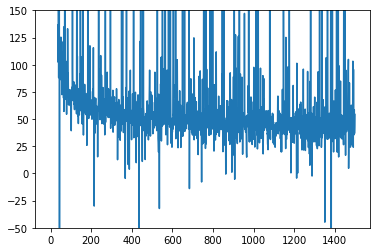


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  3090
0 and 1 are independent with pval_d=0.0021521161938737165 and pval_i=0.36483954209581176
0 and 2 are independent with pval_d=1.039362295843783e-05 and pval_i=0.97034005554015
0 and 3 are independent with pval_d=0.0029332268154571677 and pval_i=0.9240506804752376
0 and 4 are independent with pval_d=0.1580308882921816 and pval_i=0.9991166717591572
0 and 5 are independent with pval_d=0.05230214563879516 and pval_i=0.9838381038450179
0 and 6 are independent with pval_d=0.01670584337668899 and pval_i=0.5612573239233345
0 and 7 are independent with pval_d=0.6758698389267759 and pval_i=0.880505056251389
0 and 8 are independent with pval_d=0.009354332228106116 and pval_i=0.8505597937723723
0 and 9 are independent with pval_d=0.5225212402402029 and pval_i=0.9891840346866497
0 and 10 are independent with pval_d=0.08673342948056573 and pval_i=0.999544631700159
0 and 11 are independent with pval_d=0.00857790816171

  0%|          | 0/100 [00:00<?, ?it/s]

generated stored_x, stored_z with shape =  (1000000, 12)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:03<04:58,  3.02s/it]

0 791.5635252594948


  2%|▏         | 2/100 [00:06<04:58,  3.05s/it]

1 790.0895866751671


  3%|▎         | 3/100 [00:09<04:57,  3.06s/it]

2 789.8454309105873


  4%|▍         | 4/100 [00:12<04:54,  3.06s/it]

3 789.7656654119492


  5%|▌         | 5/100 [00:15<04:53,  3.09s/it]

4 789.5996207594872


  6%|▌         | 6/100 [00:18<04:49,  3.08s/it]

5 789.4925517439842


  7%|▋         | 7/100 [00:21<04:45,  3.07s/it]

6 789.4414010047913


  8%|▊         | 8/100 [00:24<04:43,  3.08s/it]

7 789.3762809038162


  9%|▉         | 9/100 [00:27<04:40,  3.08s/it]

8 789.3009853959084


 10%|█         | 10/100 [00:30<04:36,  3.08s/it]

9 789.2232133150101


 11%|█         | 11/100 [00:33<04:33,  3.08s/it]

10 789.1961287260056


 12%|█▏        | 12/100 [00:36<04:30,  3.08s/it]

11 789.110644698143


 13%|█▎        | 13/100 [00:40<04:27,  3.08s/it]

12 789.0520750880241


 14%|█▍        | 14/100 [00:43<04:24,  3.07s/it]

13 789.1133764386177


 15%|█▌        | 15/100 [00:46<04:20,  3.07s/it]

14 789.0402421355247


 16%|█▌        | 16/100 [00:49<04:19,  3.08s/it]

15 788.9738540053368


 17%|█▋        | 17/100 [00:52<04:16,  3.10s/it]

16 788.9622955322266


 18%|█▊        | 18/100 [00:55<04:14,  3.11s/it]

17 788.9597520828247


 19%|█▉        | 19/100 [00:58<04:11,  3.10s/it]

18 788.9579394459724


 20%|██        | 20/100 [01:01<04:08,  3.11s/it]

19 788.9089797735214


 21%|██        | 21/100 [01:04<04:04,  3.10s/it]

20 788.9073730111122


 22%|██▏       | 22/100 [01:07<04:00,  3.08s/it]

21 788.9050456881523


 23%|██▎       | 23/100 [01:10<03:57,  3.08s/it]

22 788.9144822359085


 24%|██▍       | 24/100 [01:14<03:56,  3.11s/it]

23 788.844803750515


 25%|██▌       | 25/100 [01:17<03:53,  3.12s/it]

24 788.8351091146469


 26%|██▌       | 26/100 [01:20<03:49,  3.11s/it]

25 788.9257492423058


 27%|██▋       | 27/100 [01:23<03:46,  3.10s/it]

26 788.8462211489677


 28%|██▊       | 28/100 [01:26<03:41,  3.07s/it]

27 788.8316601514816


 29%|██▉       | 29/100 [01:29<03:37,  3.06s/it]

28 788.8842647075653


 30%|███       | 30/100 [01:32<03:34,  3.07s/it]

29 788.7847484350204


 31%|███       | 31/100 [01:35<03:32,  3.07s/it]

30 788.7894753217697


 32%|███▏      | 32/100 [01:38<03:30,  3.09s/it]

31 788.8706464767456


 33%|███▎      | 33/100 [01:41<03:26,  3.08s/it]

32 788.7769946455956


 34%|███▍      | 34/100 [01:44<03:23,  3.08s/it]

33 788.7970880866051


 35%|███▌      | 35/100 [01:47<03:19,  3.08s/it]

34 788.8619014024734


 36%|███▌      | 36/100 [01:51<03:16,  3.06s/it]

35 788.8406153321266


 37%|███▋      | 37/100 [01:54<03:12,  3.06s/it]

36 788.7231184244156


 38%|███▊      | 38/100 [01:57<03:09,  3.05s/it]

37 788.8486933112144


 39%|███▉      | 39/100 [02:00<03:06,  3.06s/it]

38 788.7498118281364


 40%|████      | 40/100 [02:03<03:03,  3.06s/it]

39 788.8315842151642


 41%|████      | 41/100 [02:06<03:00,  3.06s/it]

40 788.7774088382721


 42%|████▏     | 42/100 [02:09<02:57,  3.05s/it]

41 788.7469108104706


 43%|████▎     | 43/100 [02:12<02:53,  3.05s/it]

42 788.7580474019051


 44%|████▍     | 44/100 [02:15<02:51,  3.06s/it]

43 788.7122039198875


 45%|████▌     | 45/100 [02:18<02:47,  3.04s/it]

44 788.7307226657867


 46%|████▌     | 46/100 [02:21<02:44,  3.04s/it]

45 788.7467907071114


 47%|████▋     | 47/100 [02:24<02:40,  3.03s/it]

46 788.7497674226761


 48%|████▊     | 48/100 [02:27<02:37,  3.03s/it]

47 788.7257832884789


 49%|████▉     | 49/100 [02:30<02:34,  3.04s/it]

48 788.7309881448746


 50%|█████     | 50/100 [02:33<02:32,  3.05s/it]

49 788.7558790445328


 51%|█████     | 51/100 [02:36<02:30,  3.06s/it]

50 788.7506258487701


 52%|█████▏    | 52/100 [02:39<02:26,  3.05s/it]

51 788.6560714244843


 53%|█████▎    | 53/100 [02:42<02:22,  3.04s/it]

52 788.6803433895111


 54%|█████▍    | 54/100 [02:45<02:20,  3.06s/it]

53 788.6947911381721


 55%|█████▌    | 55/100 [02:48<02:17,  3.05s/it]

54 788.7225719690323


 56%|█████▌    | 56/100 [02:51<02:14,  3.05s/it]

55 788.7051517367363


 57%|█████▋    | 57/100 [02:54<02:10,  3.04s/it]

56 788.6904829740524


 58%|█████▊    | 58/100 [02:58<02:09,  3.08s/it]

57 788.670306622982


 59%|█████▉    | 59/100 [03:01<02:05,  3.07s/it]

58 788.6347100138664


 60%|██████    | 60/100 [03:04<02:02,  3.06s/it]

59 788.7414389848709


 61%|██████    | 61/100 [03:07<01:59,  3.08s/it]

60 788.6670327782631


 62%|██████▏   | 62/100 [03:10<01:56,  3.06s/it]

61 788.5839922428131


 63%|██████▎   | 63/100 [03:13<01:53,  3.06s/it]

62 788.6905224919319


 64%|██████▍   | 64/100 [03:16<01:49,  3.05s/it]

63 788.6339287757874


 65%|██████▌   | 65/100 [03:19<01:46,  3.04s/it]

64 788.6813378930092


 66%|██████▌   | 66/100 [03:22<01:43,  3.03s/it]

65 788.6920073628426


 67%|██████▋   | 67/100 [03:25<01:40,  3.03s/it]

66 788.6470640301704


 68%|██████▊   | 68/100 [03:28<01:36,  3.02s/it]

67 788.6354373693466


 69%|██████▉   | 69/100 [03:31<01:33,  3.02s/it]

68 788.6710090041161


 70%|███████   | 70/100 [03:34<01:30,  3.03s/it]

69 788.7449615597725


 71%|███████   | 71/100 [03:37<01:28,  3.05s/it]

70 788.6512953042984


 72%|███████▏  | 72/100 [03:40<01:25,  3.05s/it]

71 788.5849843025208


 73%|███████▎  | 73/100 [03:43<01:22,  3.05s/it]

72 788.6558450460434


 74%|███████▍  | 74/100 [03:46<01:19,  3.04s/it]

73 788.6390209197998


 75%|███████▌  | 75/100 [03:49<01:15,  3.03s/it]

74 788.6165059804916


 76%|███████▌  | 76/100 [03:52<01:12,  3.03s/it]

75 788.6315810084343


 77%|███████▋  | 77/100 [03:55<01:09,  3.04s/it]

76 788.6480608582497


 78%|███████▊  | 78/100 [03:58<01:06,  3.05s/it]

77 788.5967752933502


 79%|███████▉  | 79/100 [04:02<01:03,  3.05s/it]

78 788.6046527028084


 80%|████████  | 80/100 [04:05<01:00,  3.05s/it]

79 788.5660964250565


 81%|████████  | 81/100 [04:08<00:58,  3.07s/it]

80 788.5981189012527


 82%|████████▏ | 82/100 [04:11<00:55,  3.07s/it]

81 788.6135158538818


 83%|████████▎ | 83/100 [04:14<00:52,  3.08s/it]

82 788.5956286787987


 84%|████████▍ | 84/100 [04:17<00:48,  3.06s/it]

83 788.5844405293465


 85%|████████▌ | 85/100 [04:20<00:45,  3.05s/it]

84 788.6184563040733


 86%|████████▌ | 86/100 [04:23<00:42,  3.04s/it]

85 788.5505073070526


 87%|████████▋ | 87/100 [04:26<00:39,  3.03s/it]

86 788.5386025309563


 88%|████████▊ | 88/100 [04:29<00:36,  3.04s/it]

87 788.6209673881531


 89%|████████▉ | 89/100 [04:32<00:33,  3.04s/it]

88 788.5703123211861


 90%|█████████ | 90/100 [04:35<00:30,  3.04s/it]

89 788.5589691996574


 91%|█████████ | 91/100 [04:38<00:27,  3.04s/it]

90 788.5779706835747


 92%|█████████▏| 92/100 [04:41<00:24,  3.05s/it]

91 788.5670034885406


 93%|█████████▎| 93/100 [04:44<00:21,  3.04s/it]

92 788.6162627339363


 94%|█████████▍| 94/100 [04:47<00:18,  3.05s/it]

93 788.4831957817078


 95%|█████████▌| 95/100 [04:50<00:15,  3.05s/it]

94 788.5243148803711


 96%|█████████▌| 96/100 [04:53<00:12,  3.05s/it]

95 788.5555037856102


 97%|█████████▋| 97/100 [04:57<00:09,  3.08s/it]

96 788.5571032166481


 98%|█████████▊| 98/100 [05:00<00:06,  3.08s/it]

97 788.5108901262283


 99%|█████████▉| 99/100 [05:03<00:03,  3.08s/it]

98 788.5328359007835


100%|██████████| 100/100 [05:06<00:00,  3.09s/it]

99 788.5144314169884

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 1.3820174932479858	

epoch 9000/10000, policy loss 1.0450142621994019	
***** test student *****
epoch 0/100 return: -794.5306603748504
epoch 1/100 return: -542.6025023535989
epoch 2/100 return: -630.9363599487449
epoch 3/100 return: -508.79119844247816
epoch 4/100 return: -533.2724323646528
epoch 5/100 return: -639.396100744372
epoch 6/100 return: -786.4142620522651
epoch 7/100 return: -627.1239627869145
epoch 8/100 return: -381.85160505734774
epoch 9/100 return: -582.8908749588375
epoch 10/100 return: -435.3226297504148
epoch 11/100 return: -365.2158752437665
epoch 12/100 return: -711.6881018536503
epoch 13/100 return: -604.7895766959064
epoch 14/100 return: -969.2041623150844
epoch 15/100 return: -771.9282021769548
epoch 16/100 return: -575.2310503222577
epoch 17/100 return: -440.13491891252454
epoch 18/100 return: -435.08269822081246
epoch 19/100 return: -724.2258746104104
epoch 20/100 return: -1648.1995566417258
epoch 21/100 return: -777.2738735310649
epoch 22/100 return: -485.44136069325594
epoch 23/1

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 12

 ***** Start Phase 1 ***** 

latent dim =  12
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (1453, 12)
epoch 1400/1500 	loss: 44.21097183227539best loss model loaded, stored at update # 857


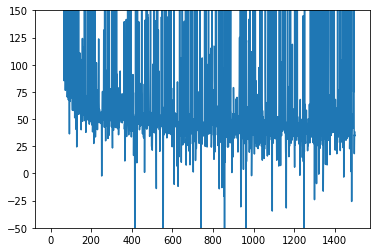


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  2906
0 and 1 are independent with pval_d=0.0011990634399324284 and pval_i=0.8130053451199979
0 and 2 are independent with pval_d=0.0760875624346365 and pval_i=0.9339806997723703
0 and 3 are independent with pval_d=0.5387860557404165 and pval_i=0.9821762911269423
0 and 4 are independent with pval_d=0.9143687844309639 and pval_i=0.9925850335078985
0 and 5 are independent with pval_d=0.6558999182651488 and pval_i=0.9993526196008449
0 and 6 are independent with pval_d=0.008308703229451982 and pval_i=0.5798897005141825
0 and 7 are independent with pval_d=0.0203291132286065 and pval_i=0.033564419407840454
0 and 8 are independent with pval_d=0.022838736228906472 and pval_i=0.695132150994613
0 and 9 are independent with pval_d=0.3388374894596964 and pval_i=0.9924381790936426
0 and 10 are independent with pval_d=0.26977697945107226 and pval_i=0.7160898259745094
0 and 11 are DEPENDENT with pval_d=0.011850709323321659

  0%|          | 0/100 [00:00<?, ?it/s]

generated stored_x, stored_z with shape =  (1000000, 12)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:03<05:06,  3.10s/it]

0 845.2284287214279


  2%|▏         | 2/100 [00:06<05:05,  3.12s/it]

1 844.0515160560608


  3%|▎         | 3/100 [00:09<05:01,  3.11s/it]

2 843.8991695046425


  4%|▍         | 4/100 [00:12<05:00,  3.13s/it]

3 843.7052077054977


  5%|▌         | 5/100 [00:15<04:56,  3.12s/it]

4 843.6795315742493


  6%|▌         | 6/100 [00:18<04:51,  3.10s/it]

5 843.6464603543282


  7%|▋         | 7/100 [00:21<04:47,  3.09s/it]

6 843.6006911993027


  8%|▊         | 8/100 [00:24<04:45,  3.10s/it]

7 843.5309709906578


  9%|▉         | 9/100 [00:27<04:40,  3.09s/it]

8 843.6151524186134


 10%|█         | 10/100 [00:31<04:37,  3.08s/it]

9 843.4803781509399


 11%|█         | 11/100 [00:34<04:36,  3.10s/it]

10 843.5377233028412


 12%|█▏        | 12/100 [00:37<04:33,  3.11s/it]

11 843.4677724838257


 13%|█▎        | 13/100 [00:40<04:28,  3.09s/it]

12 843.5074147582054


 14%|█▍        | 14/100 [00:43<04:25,  3.09s/it]

13 843.4794144630432


 15%|█▌        | 15/100 [00:46<04:22,  3.09s/it]

14 843.45400005579


 16%|█▌        | 16/100 [00:49<04:20,  3.10s/it]

15 843.4401094317436


 17%|█▋        | 17/100 [00:52<04:16,  3.09s/it]

16 843.4542391896248


 18%|█▊        | 18/100 [00:55<04:12,  3.08s/it]

17 843.4253517389297


 19%|█▉        | 19/100 [00:58<04:08,  3.07s/it]

18 843.4311448931694


 20%|██        | 20/100 [01:01<04:04,  3.06s/it]

19 843.4541872143745


 21%|██        | 21/100 [01:04<04:01,  3.05s/it]

20 843.4460783004761


 22%|██▏       | 22/100 [01:07<03:58,  3.05s/it]

21 843.457954287529


 23%|██▎       | 23/100 [01:10<03:54,  3.05s/it]

22 843.4618120789528


 24%|██▍       | 24/100 [01:14<03:51,  3.05s/it]

23 843.4278262257576


 25%|██▌       | 25/100 [01:16<03:47,  3.03s/it]

24 843.40516269207


 26%|██▌       | 26/100 [01:20<03:44,  3.03s/it]

25 843.4756000041962


 27%|██▋       | 27/100 [01:23<03:42,  3.05s/it]

26 843.4090601205826


 28%|██▊       | 28/100 [01:26<03:39,  3.05s/it]

27 843.4360702037811


 29%|██▉       | 29/100 [01:29<03:37,  3.06s/it]

28 843.4350038170815


 30%|███       | 30/100 [01:32<03:33,  3.06s/it]

29 843.4207671284676


 31%|███       | 31/100 [01:35<03:31,  3.07s/it]

30 843.4207039475441


 32%|███▏      | 32/100 [01:38<03:27,  3.06s/it]

31 843.3786262273788


 33%|███▎      | 33/100 [01:41<03:24,  3.06s/it]

32 843.3793355226517


 34%|███▍      | 34/100 [01:44<03:22,  3.07s/it]

33 843.3805192708969


 35%|███▌      | 35/100 [01:47<03:18,  3.05s/it]

34 843.3954765200615


 36%|███▌      | 36/100 [01:50<03:15,  3.05s/it]

35 843.361263692379


 37%|███▋      | 37/100 [01:53<03:11,  3.04s/it]

36 843.3767899274826


 38%|███▊      | 38/100 [01:56<03:08,  3.04s/it]

37 843.3722102046013


 39%|███▉      | 39/100 [01:59<03:05,  3.05s/it]

38 843.3905131816864


 40%|████      | 40/100 [02:02<03:02,  3.04s/it]

39 843.3932923674583


 41%|████      | 41/100 [02:05<02:59,  3.04s/it]

40 843.4099920988083


 42%|████▏     | 42/100 [02:08<02:56,  3.04s/it]

41 843.3795740008354


 43%|████▎     | 43/100 [02:11<02:53,  3.04s/it]

42 843.354489505291


 44%|████▍     | 44/100 [02:14<02:50,  3.05s/it]

43 843.3848401904106


 45%|████▌     | 45/100 [02:18<02:47,  3.05s/it]

44 843.3165782690048


 46%|████▌     | 46/100 [02:21<02:44,  3.04s/it]

45 843.3994737267494


 47%|████▋     | 47/100 [02:24<02:41,  3.05s/it]

46 843.3890768289566


 48%|████▊     | 48/100 [02:27<02:38,  3.06s/it]

47 843.3592247962952


 49%|████▉     | 49/100 [02:30<02:35,  3.06s/it]

48 843.3708478212357


 50%|█████     | 50/100 [02:33<02:33,  3.08s/it]

49 843.3755209445953


 51%|█████     | 51/100 [02:36<02:30,  3.07s/it]

50 843.3718365430832


 52%|█████▏    | 52/100 [02:39<02:27,  3.07s/it]

51 843.3346630930901


 53%|█████▎    | 53/100 [02:42<02:23,  3.06s/it]

52 843.3507317304611


 54%|█████▍    | 54/100 [02:45<02:20,  3.06s/it]

53 843.3350042104721


 55%|█████▌    | 55/100 [02:48<02:17,  3.06s/it]

54 843.3350486159325


 56%|█████▌    | 56/100 [02:51<02:14,  3.06s/it]

55 843.3872418999672


 57%|█████▋    | 57/100 [02:54<02:11,  3.05s/it]

56 843.3064025044441


 58%|█████▊    | 58/100 [02:57<02:09,  3.07s/it]

57 843.3551042079926


 59%|█████▉    | 59/100 [03:00<02:06,  3.07s/it]

58 843.3224295973778


 60%|██████    | 60/100 [03:04<02:03,  3.08s/it]

59 843.3332999944687


 61%|██████    | 61/100 [03:07<02:00,  3.09s/it]

60 843.3062212467194


 62%|██████▏   | 62/100 [03:10<01:57,  3.08s/it]

61 843.3563480973244


 63%|██████▎   | 63/100 [03:13<01:54,  3.09s/it]

62 843.3420198559761


 64%|██████▍   | 64/100 [03:16<01:51,  3.09s/it]

63 843.3158249855042


 65%|██████▌   | 65/100 [03:19<01:47,  3.07s/it]

64 843.3402746915817


 66%|██████▌   | 66/100 [03:22<01:44,  3.06s/it]

65 843.3213517665863


 67%|██████▋   | 67/100 [03:25<01:41,  3.06s/it]

66 843.3323233127594


 68%|██████▊   | 68/100 [03:28<01:38,  3.07s/it]

67 843.3279742002487


 69%|██████▉   | 69/100 [03:31<01:34,  3.06s/it]

68 843.3343478441238


 70%|███████   | 70/100 [03:34<01:32,  3.07s/it]

69 843.3212050795555


 71%|███████   | 71/100 [03:37<01:28,  3.07s/it]

70 843.3149464726448


 72%|███████▏  | 72/100 [03:40<01:25,  3.06s/it]

71 843.3273169398308


 73%|███████▎  | 73/100 [03:43<01:22,  3.05s/it]

72 843.2993769645691


 74%|███████▍  | 74/100 [03:46<01:19,  3.05s/it]

73 843.2786938548088


 75%|███████▌  | 75/100 [03:50<01:16,  3.06s/it]

74 843.3249220848083


 76%|███████▌  | 76/100 [03:53<01:13,  3.05s/it]

75 843.2740803956985


 77%|███████▋  | 77/100 [03:56<01:10,  3.05s/it]

76 843.3234234452248


 78%|███████▊  | 78/100 [03:59<01:07,  3.05s/it]

77 843.2875217795372


 79%|███████▉  | 79/100 [04:02<01:03,  3.04s/it]

78 843.3103860020638


 80%|████████  | 80/100 [04:05<01:01,  3.06s/it]

79 843.338800907135


 81%|████████  | 81/100 [04:08<00:58,  3.09s/it]

80 843.3144680261612


 82%|████████▏ | 82/100 [04:11<00:55,  3.07s/it]

81 843.3241218328476


 83%|████████▎ | 83/100 [04:14<00:51,  3.05s/it]

82 843.2658014297485


 84%|████████▍ | 84/100 [04:17<00:48,  3.04s/it]

83 843.2655831575394


 85%|████████▌ | 85/100 [04:20<00:45,  3.05s/it]

84 843.32503002882


 86%|████████▌ | 86/100 [04:23<00:42,  3.03s/it]

85 843.3633376955986


 87%|████████▋ | 87/100 [04:26<00:39,  3.04s/it]

86 843.3013604283333


 88%|████████▊ | 88/100 [04:29<00:36,  3.04s/it]

87 843.2499032020569


 89%|████████▉ | 89/100 [04:32<00:33,  3.04s/it]

88 843.3254643678665


 90%|█████████ | 90/100 [04:35<00:30,  3.04s/it]

89 843.3021119832993


 91%|█████████ | 91/100 [04:38<00:27,  3.06s/it]

90 843.2937135696411


 92%|█████████▏| 92/100 [04:41<00:24,  3.05s/it]

91 843.2847329974174


 93%|█████████▎| 93/100 [04:44<00:21,  3.04s/it]

92 843.2666424512863


 94%|█████████▍| 94/100 [04:48<00:18,  3.07s/it]

93 843.284393966198


 95%|█████████▌| 95/100 [04:51<00:15,  3.09s/it]

94 843.2362957596779


 96%|█████████▌| 96/100 [04:54<00:12,  3.09s/it]

95 843.3060014247894


 97%|█████████▋| 97/100 [04:57<00:09,  3.07s/it]

96 843.275055706501


 98%|█████████▊| 98/100 [05:00<00:06,  3.08s/it]

97 843.3155927062035


 99%|█████████▉| 99/100 [05:03<00:03,  3.07s/it]

98 843.3037303090096


100%|██████████| 100/100 [05:06<00:00,  3.05s/it]

99 843.2916689515114

***** train student policy network *****
train in NFiVAE
epoch 0/10000, policy loss 1.426471471786499	

epoch 9000/10000, policy loss 1.073061227798462	
***** test student *****
epoch 0/100 return: -598.1622113225992
epoch 1/100 return: -873.9786367370288
epoch 2/100 return: -1678.3167172626736
epoch 3/100 return: -660.586545836648
epoch 4/100 return: -427.9883597545276
epoch 5/100 return: -613.291116175041
epoch 6/100 return: -860.1338480636335
epoch 7/100 return: -373.2593919329706
epoch 8/100 return: -1131.9238132693658
epoch 9/100 return: -883.3190076614674
epoch 10/100 return: -688.3177694163429
epoch 11/100 return: -855.9903419600487
epoch 12/100 return: -1882.2336011565114
epoch 13/100 return: -982.9850184579983
epoch 14/100 return: -416.3352908625024
epoch 15/100 return: -719.7477703717094
epoch 16/100 return: -566.2275099956669
epoch 17/100 return: -1887.2985785879264
epoch 18/100 return: -786.7162742656332
epoch 19/100 return: -654.3654862158793
epoch 20/100 return: -861.6075171744646
epoch 21/100 return: -808.7451094141483
epoch 22/100 return: -826.0208176652221
epoch 23/100 r

/content/drive/.shortcut-targets-by-id/15_BhZyJSvQWMTBbzA9iHkhBymeY5HxXY/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 12

 ***** Start Phase 1 ***** 

latent dim =  12
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (1579, 12)
epoch 1400/1500 	loss: 42.90928649902344best loss model loaded, stored at update # 1397


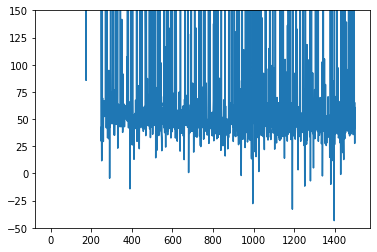


 ***** Start Phase 2 ***** 


***** Starts Phase 2 *****
phase 2: n_samples =  3158
0 and 1 are independent with pval_d=0.1515172995114916 and pval_i=0.5842187639563252
0 and 2 are independent with pval_d=0.015188663199804399 and pval_i=0.8337860894016715
0 and 3 are independent with pval_d=0.11687787162478144 and pval_i=0.99926567145837
0 and 4 are independent with pval_d=0.6804607636400771 and pval_i=0.9998957245792991
0 and 5 are independent with pval_d=0.11372712773632897 and pval_i=0.9959690549198335
0 and 6 are independent with pval_d=0.06098407417728437 and pval_i=0.9641818468654562
0 and 7 are independent with pval_d=0.12405395363781772 and pval_i=0.8067611489209899
0 and 8 are independent with pval_d=0.09812133285066361 and pval_i=0.989887000553062
0 and 9 are independent with pval_d=0.43175014828091357 and pval_i=0.9751621332058686
0 and 10 are independent with pval_d=0.002013860797295315 and pval_i=0.9744381066945225
0 and 11 are independent with pval_d=0.012136788897799787

  0%|          | 0/100 [00:00<?, ?it/s]

generated stored_x, stored_z with shape =  (1000000, 12)

***** phase3 obs->latent encoder *****
 *** start training phase3 obs->latent encoder *** 


  1%|          | 1/100 [00:02<04:56,  3.00s/it]

0 785.7237649559975


  2%|▏         | 2/100 [00:06<04:57,  3.04s/it]

1 784.7675791978836


  3%|▎         | 3/100 [00:09<04:54,  3.04s/it]

2 784.3577633500099


  4%|▍         | 4/100 [00:12<04:51,  3.04s/it]

3 784.0849739909172


  5%|▌         | 5/100 [00:15<04:49,  3.05s/it]

4 783.8665543794632


  6%|▌         | 6/100 [00:18<04:48,  3.07s/it]

5 783.7640419006348


  7%|▋         | 7/100 [00:21<04:44,  3.06s/it]

6 783.603756248951


  8%|▊         | 8/100 [00:24<04:41,  3.06s/it]

7 783.5425499677658


  9%|▉         | 9/100 [00:27<04:39,  3.07s/it]

8 783.4839974045753


 10%|█         | 10/100 [00:30<04:37,  3.08s/it]

9 783.3902499079704


 11%|█         | 11/100 [00:33<04:34,  3.09s/it]

10 783.3879560828209


KeyboardInterrupt: ignored

In [8]:
config['METHOD'] = "iVAE_IRM"

for traj_num in [16]: # , 4, 8, 16, 32, 64, 128]:
    #if True:
    #    traj_num = 2

    config["NUM_TRAJS_GIVEN"] = traj_num
    config["TRAJ_SHIFT"] = traj_num


    config['ALG'] = "test13_Apr30_FINAL_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


    ###############.  settings   ###############
    #config['ALG'] = "ICILStudent_Apr19_replicatedata"
    #config['METHOD'] = "ICIL"
    #config['ENV'] == "CartPole-v1"
    #config['ENV'] == "LunarLander-v2"

    ###############.  settings   ###############

    #if config['METHOD'] == 'iVAE_IRM':
    

    all_results_trail = []

    for trail in range(1): 
        config['TRIAL'] = trail 

        print("batch size = ", config['BATCH_SIZE'])


        ###############.  start a trail   ###############

        config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
        print("Config: %s" % config)

        TRIAL = config["TRIAL"] #args.trial
        print("Trial number %s" % TRIAL)

        results_dir_base = "testing/results/"
        results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

        results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
        results_file_path = os.path.join(results_dir, results_file_name)

        if os.path.exists(os.path.join(results_dir, config_file)):
            raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
        pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




        ###############.  10 runs for each trail   ###############

        print("config method = ", config['METHOD'])
        print("config env = ", config['ENV'])

        for run_seed in range(config["NUM_REPETITIONS"]):
            print("Run %s out of %s" % (run_seed + 1, config["NUM_REPETITIONS"]))

            print("\n***** make student *****")
            student = make_student(run_seed, config)

            print("\n***** generated stored data *****")
            student.config['dim_list'] = None #[0,1,2,3]
            student.generating_stored_data()

            #break

            print("\n***** phase3 obs->latent encoder *****")
            student.gen_phase3_obs_to_latent_encoder(phase3_encoder_lr = 0.01, phase3_bs = 1024, phase3_epochs = 100)

            print("\n***** train student policy network *****")
            student.train(num_updates=config["NUM_STEPS_TRAIN"])

            env_wrapper_out_of_sample = EnvWrapper(
                env=gym.make(config["ENV"]), mult_factor=get_test_mult_factors(config['NOISE_DIM'] - 1), idx=3, seed=1)

            print("\n***** test student *****")
            action_match, return_mean, return_std = student.test(
                num_episodes=config["NUM_TRAJS_VALID"], env_wrapper=env_wrapper_out_of_sample)

            result = (action_match, return_mean, return_std)
            print("###############    Reward for test environment for run %s: %s.   ###############\n\n" % (run_seed + 1, return_mean))
            save_results(results_file_path, run_seed, action_match, return_mean, return_std)

        results_trial = pd.read_csv(
            "testing/results/"
            + config["ENV"]
            + "/"
            + str(config["NUM_TRAJS_GIVEN"])
            + "/"
            + config["ALG"]
            + "/trial_"
            + str(TRIAL)
            + "_results.csv",
            header=None,
        )

        print("Average reward for 10 repetitions: %s" % np.mean(results_trial[2].values))

        all_results_trail.append(np.mean(results_trial[2].values))

    print("ALL RESULTS TRAIL:" , all_results_trail)

In [7]:

class Phase3ObstoLatentEncoder(nn.Module):
    def __init__(self, obs_size, latent_size):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(obs_size, 32),
            nn.ELU(),
            nn.Linear(32, 64),
            nn.ELU(),
            nn.Linear(64,  32),
            nn.ELU(),          
            nn.Linear(32, latent_size))

    def forward(self, x):
        return self.layers(x)


In [8]:
self = student 
phase3_encoder_lr = 0.01
phase3_bs = 1024

import random 
phase3_encoder = Phase3ObstoLatentEncoder(self.vae_wrapper.state_dim, len(self.vae_wrapper.pa_list)).to(self.device)


phase3_optimizer = torch.optim.Adam(phase3_encoder.parameters(), lr=phase3_encoder_lr)

total_idxs = list(range(len(self.stored_z)))
n_batch = len(self.stored_z) // phase3_bs + 1
phase3_loss_list = []

epoch = 0
j = 0

#for epoch in tqdm(range(phase3_epochs)):
random.shuffle(total_idxs)
phase3_epoch_loss = 0

In [13]:
phase3_encoder = phase3_encoder.to(self.device)

In [15]:
#    for j in range(n_batch):
batch_idxs = total_idxs[j * phase3_bs : (j + 1) * phase3_bs]
batch_x = torch.as_tensor(self.stored_x[batch_idxs], device=self.device)#.long()
batch_z = torch.as_tensor(self.stored_z[batch_idxs], device=self.device)#.long()
masked_batch_z = batch_z[:,self.vae_wrapper.pa_list]


In [24]:
torch.as_tensor(self.stored_x[batch_idxs]).to(self.device)

RuntimeError: ignored

In [ ]:

phase3_optimizer.zero_grad() 

In [14]:
z_pred = phase3_encoder(batch_x)

RuntimeError: ignored

In [11]:


z_pred = phase3_encoder(batch_x)
#phase3_loss =  nn.L1Loss()(z_pred, batch_z)
phase3_loss =  nn.L1Loss()(z_pred, masked_batch_z)
phase3_loss.backward() 
phase3_optimizer.step() 
phase3_epoch_loss += phase3_loss.detach().cpu().item()

print(epoch, phase3_epoch_loss)

self.phase3_obs_to_latent_encoder = phase3_encoder


RuntimeError: ignored